In [1]:
from skorch.net import NeuralNet
from model.model import OneStageHidden, MMS
import torch.nn as nn
import pandas as pd
from skorch.net import NeuralNet
from model.net import Net
import torch
import numpy as np
from skorch.helper import predefined_split
from skorch.dataset import Dataset
from sklearn.metrics import explained_variance_score
from argparse import ArgumentParser
from gensimulation import gen_simulation
import sys
from sklearn import linear_model

sys.argv = ['main.py']

In [2]:
nstage = 9
hidden_size = 10
nonactivate = None
noiselevel = 0.5
Ntrain = 500
Nvalidation = 500
hidden2_size = 0
Ntest = 2000
isindi = False
l1weight = 0.001
l2weight = 0.0001
lr = 0.01
icase = 1
seed = 0


def get_args():
    parser = ArgumentParser(description='PyTorch MMS Simulation')
    parser.add_argument('--experiment', type=str, default='case1')    
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--isindi', type=bool, default=False)
    args = parser.parse_args()
    return args

Xdataall_pd, Xtrain_t,ytrain_t,Xval_t,yval_t, Xtest_t,ytest_t,valid_ds,levelf,levelv = gen_simulation('case3', Ntrain,Nvalidation,Ntest)


args = get_args()
globals().update(args.__dict__)
allexperiments = ['case1','case2','case3']

clfall = [[]  for i in allexperiments]


epscore = [[] for i in allexperiments]

Xtrain_pd = pd.DataFrame(data = Xtrain_t.data.numpy(), columns =  levelf)
Xtest_pd = pd.DataFrame(data = Xtest_t.data.numpy(), columns =  levelf)


In [5]:

for iexperiment,experiment in enumerate(allexperiments):
    N = Ntrain + Ntest + Nvalidation
    Xdataall_pd, Xtrain_t,ytrain_t,Xval_t,yval_t, Xtest_t,ytest_t,valid_ds,levelf,levelv = gen_simulation(experiment, Ntrain,Nvalidation,Ntest)
    ytrain_pd = pd.DataFrame(data = ytrain_t.data.numpy(), columns =  levelv)
    ytest_pd= pd.DataFrame(data = ytest_t.data.numpy(), columns =  levelv)

    for istage in range(nstage):
        clf = linear_model.MultiTaskElasticNetCV(l1_ratio=[0.01, .1, .5, .7, .9, .95, .99, 1],alphas = [0.01,.1, 1., 2., 4.,10.,100])
        Xtrain_pd_reg = pd.concat(tuple([Xtrain_pd['f'][str(istage)] for istage in range(istage+1)]), axis=1)
        Xtest_pd_reg = pd.concat(tuple([Xtest_pd['f'][str(istage)] for istage in range(istage+1)]), axis=1)
        ytrain = ytrain_pd[str(istage)].values
        ytest = ytest_pd[str(istage)].values


        clf.fit(Xtrain_pd_reg.values,ytrain)
        y_pred = clf.predict(Xtest_pd_reg.values)
        score = np.sum((ytest-y_pred)**2,0)/np.sum((ytest-np.mean(ytrain))**2,0)
        print(istage,score)
        epscore[iexperiment].append(score)
        
    clfall[iexperiment] = clf

0 [ 0.80217677  0.77047771  0.98023254  0.99659175  0.97229493  0.96106911]
1 [ 0.88742888  0.85737395  0.98561609  0.95782322  0.95790541  1.0223906 ]
2 [ 0.8482542   0.76606351  1.0059005   0.99818021  0.99944109  0.8117466 ]
3 [ 0.99847829  0.80314988  0.91059732  0.9992336   0.95418179  0.90917516]
4 [ 0.76339787  0.96487397  0.94220293  1.00077474  0.79923785  0.75787246]
5 [ 0.9861092   0.99584615  0.99232632  1.00019658  0.82479459  0.96012372]
6 [ 0.7719754   0.80113864  0.95511961  0.95062596  0.89417517  0.99402285]
7 [ 0.93149334  0.97319204  0.87530386  0.87082922  0.89906484  0.60461622]
8 [ 0.8857187   0.9123413   0.96348792  0.69664407  0.47524524  1.00093305]
0 [ 0.11644834  0.11677627  0.76409626  0.95244867  0.86036098  0.95268863]
1 [ 0.18087332  0.04898     0.10120023  0.18000327  1.04343545  1.01968777]
2 [ 0.11680946  0.14776815  0.14871369  0.1660163   0.12912059  0.12253644]
3 [ 0.25063571  0.20614652  0.23111537  0.22170597  0.30008587  0.41843775]
4 [ 0.264038

In [17]:
import pickle
with open('MMS_simulation_MultiElasticNet.pickle','wb') as f:
    pickle.dump([clfall,epscore],f)

In [6]:
for i in range(3):
     print("{:.3f} ({:.3f})".format(np.mean(epscore[i]),np.std(epscore[i])))
    

0.898 (0.121)
0.353 (0.246)
0.184 (0.071)


In [15]:
discovernum = [ [] for i in range(3)]
allindex = np.arange(810)
for iexperiment,experiment in enumerate(allexperiments):
    if experiment == 'case1':
        informative = np.concatenate(tuple([np.arange(90*j+0,90*j+75) for j in range(9)]))
        noninformative = np.setdiff1d(allindex,informative)
    elif experiment == 'case2':
        informative = np.concatenate(tuple([np.arange(90*j+60,90*j+85) for j in range(9)]))
        noninformative  = np.concatenate([np.arange(25,30),np.arange(55,60),np.arange(85,90)])    
    else:
        s1 = np.arange(180,(180+75))
        s2 = np.arange(5*90,(5*90+75))
        s3 = np.arange(8*90,(8*90+75))
        informative = np.concatenate((s1,s2,s3))
        noninformative = np.setdiff1d(allindex,informative)
    score = np.abs(clf.coef_[5])
    discovernum[iexperiment] = (np.sum(score[informative]>np.percentile(score[noninformative],95)))/len(informative)


In [16]:
discovernum

[0.28444444444444444, 0.23999999999999999, 0.68000000000000005]

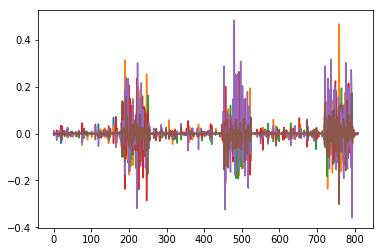

In [13]:
import matplotlib.pyplot as plt
plt.plot(clf.coef_.T)
plt.show()

In [14]:
from sklearn.metrics import auc

clf.coef_[5]

array([ -0.00000000e+00,  -6.86838385e-03,  -0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -2.64160754e-03,  -4.70268307e-03,
         0.00000000e+00,  -2.66160234e-03,  -0.00000000e+00,
         6.04729517e-04,  -0.00000000e+00,  -0.00000000e+00,
        -9.48439725e-03,  -6.42600562e-03,   0.00000000e+00,
        -0.00000000e+00,  -2.79625524e-02,   5.82492445e-03,
        -0.00000000e+00,  -1.10224560e-02,   0.00000000e+00,
        -5.43605862e-03,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,   1.38009782e-03,   8.62545520e-03,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -1.95498718e-03,  -7.01082172e-03,
        -0.00000000e+00,  -3.73251690e-03,   3.02736042e-03,
         2.65992221e-05,   0.00000000e+00,  -4.56686085e-03,
        -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,   7.81439897e-03,  -0.00000000e+00,
         0.00000000e+00,

In [48]:
discovernum

0.22814814814814816